<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-lightning/03-finetuning-with-lightning-flash/01_video_classification_using_flash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Video classification using Flash

Video classification is one of the most interesting yet challenging problems in DL. Simply
speaking, it tries to classify an action in a video clip and recognize it (such as walking,
bowling, or golfing).

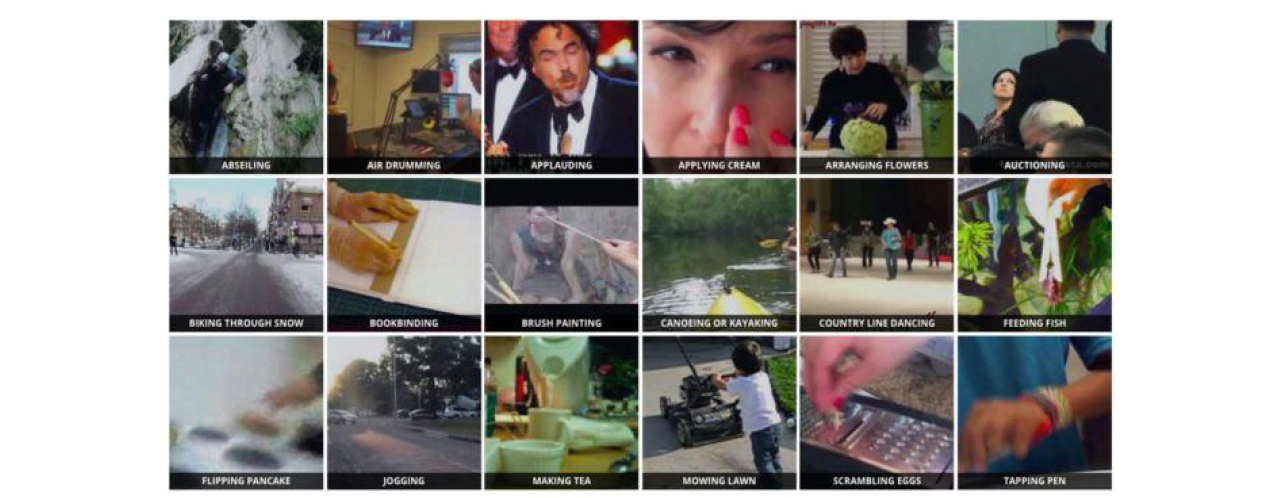

Training such a DL model is a challenging problem because of the sheer amount of
compute power it takes to train the model, given the large size of video files compared to
tabular or image data. 

Using a pre-trained model and architecture is a great way to start
your experiments for video classification.

PyTorch Lightning Flash relies internally on the `PyTorchVideo` library for its backbone.
`PyTorchVideo` caters to the ecosystem of video understanding.

In this notebook, we will be using the Kinetics 400 dataset and will then try different video
classification architectures out of the box to fine-tune the model.

##Setup

In [ ]:
#install correct version as defined in the Technical Req
!pip -q install pytorch-lightning --quiet
!pip install lightning-flash --quiet
!pip install 'lightning-flash[audio,image, video, text]' --quiet
!pip install Pillow==9.0.0

In [1]:
import torch

import pytorch_lightning as pl

import flash
from flash.core.data.utils import download_data
from flash.video import VideoClassificationData, VideoClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import urllib3
urllib3.disable_warnings()

In [3]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("flash version:",flash.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.3.5
numpy version: 1.21.6
seaborn version: 0.11.2
torch version: 1.12.1+cu113
flash version: 0.8.0
pytorch ligthening version: 1.7.7


Let's download the Kinetics 400 dataset.

In [ ]:
download_data("https://pl-flash-data.s3.amazonaws.com/kinetics.zip", "./data")

##Slow and SlowFast architecture

SlowFast is a widely used model architecture for video classification. It basically consists
of two pathways, slow and fast, for video classification.

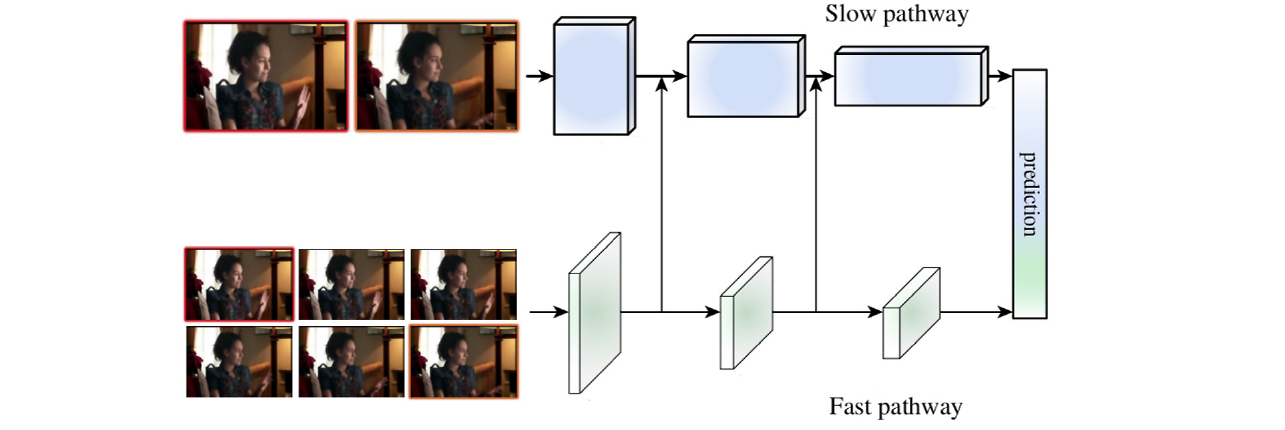

The model architecture is based on the concept of low and fast temporal frequencies
to recognize moving objects, as inspired by the retinas in our eyes. It consists of
a high-definition slow pathway to analyze static content along with a low definition fast
pathway to analyze dynamic content. 

Both pathways internally use ResNet convolution
architecture for CNN but use different temporal strides. The fast pathway uses smaller
temporal strides but a high frequency (15 frames per second), while the slow pathway uses
large temporal strides but a low frequency (2 frames per second). 

For this reason, a slow
pathway is more compute-heavy than a fast pathway.

While the results of SlowFast architecture are impressive and considered some of the best
(at about 94%), the results of just using slow or fast architecture were also published. The
results of slow architecture are also good (about 91%). 

Both these model architectures
(and many others) are available out of the box in Flash.

The video classification model using Flash will consist of the following four steps:

1. Loading the dataset
2. Configuring the backbone
3. Training and fine-tuning the model
4. Predicting actions based on the model

##Dataset

Let's read the dataset and see the head of the dataframe in pandas.

In [ ]:
pub_health_train = pd.read_csv("PUBHEALTH/train.tsv", sep="\t")
pub_health_test = pd.read_csv("PUBHEALTH/test.tsv", sep="\t")

pub_health_train.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,


##Preprocessing the dataset

In [ ]:
# "snopes" has only 27 instances, so drop it
pub_health_train = pub_health_train[pub_health_train["label"] != "snopes"]

# selecting only two columns of interest – 'main text' and 'label'
pub_health_train = pub_health_train[["main_text", "label"]]

# Finally, dropping any row that contains missing values
pub_health_train = pub_health_train.dropna(subset=["main_text", "label"])

pub_health_train.head()

,main_text,label
0,"""Hillary Clinton is in the political crosshair...",false
1,While the financial costs of screening mammogr...,mixture
2,The news release quotes lead researcher Robert...,mixture
3,"The story does discuss costs, but the framing ...",true
4,"""Although the story didn’t cite the cost of ap...",true


In [ ]:
pub_health_test = pub_health_test[["main_text", "label"]]
pub_health_test = pub_health_test.dropna(subset=["main_text", "label"])

The classes for the public health claims are false, mixture, true, and unproven.

These need to be converted into numbers so that tensors can be created from the
list of labels.

In [ ]:
pub_health_train["label"] = pub_health_train["label"].map({"true": 0, "false": 1, "unproven": 2, "mixture": 3})
pub_health_test["label"] = pub_health_test["label"].map({"true": 0, "false": 1, "unproven": 2, "mixture": 3})

##Building the model

The data transformation and any feature engineering can be done outside of our
`TextClassifier` class; however, PyTorch Lightning allows us to keep everything in one piece. 

The `prepare_data` life cycle method is triggered before any training begins;
in our case, it's triggered before other life cycle methods.

In [ ]:
class HealthClaimClassifier(pl.LightningModule):

  def __init__(self, max_seq_len=512, batch_size=128, learning_rate=0.001):
    super().__init__()

    self.learning_rate = learning_rate 
    self.max_seq_len = max_seq_len 
    self.batch_size = batch_size 
    self.loss = nn.CrossEntropyLoss()

    # let's load the pretrained BERT model
    self.pretrain_model = AutoModel.from_pretrained("bert-base-uncased")
    # set the evaluation mode so that the dropout and batch normalization layers go to evaluation mode
    self.pretrain_model.eval()

    # let's freeze the weights
    for param in self.pretrain_model.parameters():
      param.requires_grad = False

    # let's adjust the parameter size of pre-trained model by defining custom classifier head
    self.classifier_layer = nn.Sequential(
      nn.Linear(768, 512),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(512, 4),  # 4 is total number of classes
      nn.LogSoftmax(dim=1)
    )

  def prepare_data(self):
    """
    This life cycle method is loading up our public health claims dataset, tokenizing the data, and creating features and the target variable.
    """
    # let's begin by initializing BertTokenizerFast
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    # let's tokenize and encode sequences in the training/testing set
    tokens_train = tokenizer.batch_encode_plus(
      pub_health_train["main_text"].tolist(),
      max_length = self.max_seq_len,  # truncate any text data above the established maximum sequence length
      pad_to_max_length=True,         # anything following the maximum sequence length will be padded
      truncation=True,
      return_token_type_ids=False
    )

    tokens_test = tokenizer.batch_encode_plus(
      pub_health_test["main_text"].tolist(),
      max_length = self.max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
    )

    # Now, need to create features and extract the target variable from the dataset
    self.train_seq = torch.tensor(tokens_train["input_ids"])
    self.train_mask = torch.tensor(tokens_train["attention_mask"])
    self.train_y = torch.tensor(pub_health_train["label"].tolist())

    self.test_seq = torch.tensor(tokens_test["input_ids"])
    self.test_mask = torch.tensor(tokens_test["attention_mask"])
    self.test_y = torch.tensor(pub_health_test["label"].tolist())

  def forward(self, encode_id, mask):
    # let's pass the data to the pre-trained model then into custom classifier head
    _, output = self.pretrain_model(encode_id, attention_mask=mask)
    output = self.classifier_layer(output)
    return output

  def train_dataloader(self):
    train_dataset = TensorDataset(self.train_seq, self.train_mask, self.train_y)
    self.train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size)
    return self.train_dataloader
  
  def test_dataloader(self):
    test_dataset = TensorDataset(self.test_seq, self.test_mask, self.test_y)
    self.test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size)
    return self.test_dataloader

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr=self.learning_rate)
    return optimizer

  def training_step(self, batch, batch_idx):
    encode_id, mask, targets = batch
    outputs = self(encode_id, mask)
    # get the indices of the maximum value of all elements in the input tensor
    preds = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy(preds, targets)
    loss = self.loss(outputs, targets)

    self.log("train_accuracy", train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
    self.log("train_loss", loss, on_step=False, on_epoch=True)
    return {"loss": loss, "train_accuracy": train_accuracy}

  def test_step(self, batch, batch_idx):
    encode_id, mask, targets = batch
    outputs = self.forward(encode_id, mask)
    preds = torch.argmax(outputs, dim=1)
    test_accuracy = accuracy(preds, targets)
    loss = self.loss(outputs, targets)
    #self.log("test_accuracy", test_accuracy)
    return {"loss": loss, "test_accuracy": test_accuracy}

  # calculate the overall accuracy of the entire dataset
  def test_epoch_end(self, outputs):
    test_outs = []
    for test_out in outputs:
      out = test_out["test_accuracy"]
      test_outs.append(out)
    total_test_accuracy = torch.stack(test_outs).mean()
    self.log("total_test_accuracy", total_test_accuracy, on_step=False, on_epoch=True)
    return total_test_accuracy

##Training the model

In PyTorch Lightning, to train the model, we do the followings:

1. first initialize the trainer class
2. then invoke the fit method to actually train the model

In [ ]:
model = HealthClaimClassifier()

# let's check that model is ready to train
trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model)

In [ ]:
# finally, let's train the model
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)
model = HealthClaimClassifier()

trainer = pl.Trainer(default_root_dir="cnn", gpus=-1, log_every_n_steps=30, max_epochs=10, callbacks=[ckpt_callback])
trainer.fit(model)

##Evaluating the model

In [ ]:
# let's the model and check the accuracy on the test dataset
trainer.test()

We can observe that we have been able to achieve 60% accuracy on the testing dataset
with just 10 epochs and without any hyperparameter tuning. 

A model improvement
exercise on HealthClaimClassifier might even help us in getting much better
accuracy with the pre-trained BERT model.